In [1]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import struct
import torch.utils.data as Data
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

myFont = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 17,
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_images(file_name):
    binfile = open(file_name, 'rb') 
    buffers = binfile.read()
    magic,num,rows,cols = struct.unpack_from('>IIII',buffers, 0)
    bits = num * rows * cols
    images = struct.unpack_from('>' + str(bits) + 'B', buffers, struct.calcsize('>IIII'))
    binfile.close()
    images = np.reshape(images, [num, rows * cols])
    return images

images = load_images('/content/drive/MyDrive/train-images-idx3-ubyte')

In [4]:
images.shape, images.shape[0], np.expand_dims(np.reshape(images[59999], [28,28]), axis=0).shape

((60000, 784), 60000, (1, 28, 28))

In [5]:
pretraining_imgs = []
pretraining_label = []
for i in range(images.shape[0]):
    original_img = np.reshape(images[i] / 255.0, [28,28])
    degree = random.randint(0,3)
    rotated_img = np.rot90(original_img, degree)
    pretraining_imgs.append(np.expand_dims(rotated_img, axis=0))
    one_hot = np.zeros(4)
    one_hot[degree] = 1
    pretraining_label.append(one_hot)

pretraining_imgs = torch.Tensor(np.array(pretraining_imgs))
pretraining_label = torch.Tensor(np.array(pretraining_label))

In [6]:
pretraining_dataset = Data.TensorDataset(pretraining_imgs, pretraining_label)
pretraining_data_loader = Data.DataLoader(
    dataset = pretraining_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 2,
)

In [13]:
class Pre(nn.Module):
    def __init__(self):
        super(Pre, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,4,3),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(4,16,3),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(400,256),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(128,4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)
        y = x
        x = self.fc3(x)
        return x, y

pre = Pre()
pre = pre.cuda()
# summary(pre, (1,28,28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre.parameters(), lr=0.001)

In [14]:
'''
Pre-trainning: LeNet
'''
epochs = 30
pretraining_loss = []

for epoch in range(epochs):
    for inputs, labels in pretraining_data_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs, _ = pre(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch ',epoch,':',' loss = ',loss.item(),sep='')
    pretraining_loss.append(loss.item())

epoch 0: loss = 0.1550433486700058
epoch 1: loss = 0.03949423134326935
epoch 2: loss = 0.08675339818000793
epoch 3: loss = 0.032226864248514175
epoch 4: loss = 0.004602429922670126
epoch 5: loss = 0.002992745954543352
epoch 6: loss = 0.04627731442451477
epoch 7: loss = 0.055885422974824905
epoch 8: loss = 0.005326215177774429
epoch 9: loss = 0.0017246908973902464
epoch 10: loss = 0.006668668240308762
epoch 11: loss = 0.009751963429152966
epoch 12: loss = 0.03854113444685936
epoch 13: loss = 0.12153294682502747
epoch 14: loss = 0.008091399446129799
epoch 15: loss = 0.0017948737367987633
epoch 16: loss = 0.008329877629876137
epoch 17: loss = 0.0007158423541113734
epoch 18: loss = 0.0011706275399774313
epoch 19: loss = 0.014153932221233845
epoch 20: loss = 0.0005687661468982697
epoch 21: loss = 0.009763735346496105
epoch 22: loss = 0.004803177434951067
epoch 23: loss = 7.69717080402188e-05
epoch 24: loss = 0.007030815817415714
epoch 25: loss = 1.538512037768669e-06
epoch 26: loss = 0.0073

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


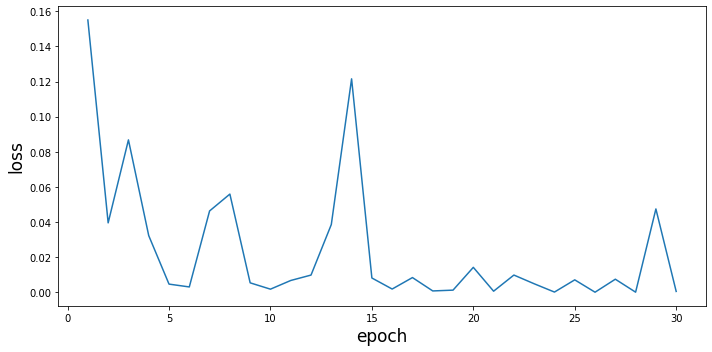

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs+1), pretraining_loss)
plt.xlabel('epoch', myFont)
plt.ylabel('loss', myFont)
plt.tight_layout()
plt.show()

In [22]:
np.save('/content/drive/MyDrive/Rotate_losslist', pretraining_loss)

In [16]:
transform = transforms.ToTensor()

data_train = datasets.MNIST(root = "./data/",
                            transform = transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(32,10)
    def forward(self, x):
        _, x = pre(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre.parameters(), lr=0.001)

In [20]:
'''
Trainning
'''
epochs = 10
# training_loss = []
 
for epoch in range(epochs):
    for inputs, labels in data_loader_train:
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch ',epoch,':',' loss = ',loss.item(),sep='')
    # training_loss.append(loss.item())


epoch 0: loss = 0.02781023643910885
epoch 1: loss = 0.05210856720805168
epoch 2: loss = 0.0015975682763382792
epoch 3: loss = 0.018549257889389992
epoch 4: loss = 0.0070768920704722404
epoch 5: loss = 0.0022655208595097065
epoch 6: loss = 0.018377643078565598
epoch 7: loss = 0.059841882437467575
epoch 8: loss = 0.006073391530662775
epoch 9: loss = 4.1655355744296685e-05


In [21]:
total = 0
correct = 0
for inputs, labels in data_loader_test:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 98.83 %
